In [3]:
## Utilities
import argparse
import random
import time
import os
import logging
from timeit import default_timer as timer
from tqdm import tqdm

## Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## Torch
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

logger = logging.getLogger("cdc")

In [65]:
##Create data_loaders
batch_size = 8

train_set = pd.read_csv("project2_TS_input/mitbih_train.csv", header=None)
test_set = pd.read_csv("project2_TS_input/mitbih_test.csv", header=None)

y_train=train_set.iloc[:,-1]
X_train = train_set.iloc[:,:-1]
y_test=test_set.iloc[:,-1]
X_test = test_set.iloc[:,:-1]

X_train_tensor = torch.tensor(X_train.values , dtype=torch.float)
y_train_tensor= torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test.values , dtype=torch.float)
y_test_tensor= torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create a DataLoader for each dataset
batch_size = 8
train_loader = data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
validation_loader = data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

# Q2: Representation Learning Model

In [5]:
##based on Github repo https://github.com/jefflai108/Contrastive-Predictive-Coding-PyTorch.git related to the paper https://arxiv.org/abs/1807.03748

class CDCK2(nn.Module):
    def __init__(self, timestep, batch_size, seq_len):

        super(CDCK2, self).__init__()

        self.batch_size = batch_size
        self.seq_len = seq_len
        self.timestep = timestep #Specifies the number of future steps to predict. e.g. 12
        self.encoder = nn.Sequential( # downsampling factor = 4
            # First conv layer to increase channel depth
            nn.Conv1d(1, 64, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            # Second conv layer to downsample
            nn.Conv1d(64, 64, kernel_size=5, stride=4, padding=1, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
        )
        self.gru = nn.GRU(64, 256, num_layers=1, bidirectional=False, batch_first=True) #A type of recurrent neural network used for sequence modeling, here to capture temporal dependencies in the encoded data
        self.Wk  = nn.ModuleList([nn.Linear(256, 64) for i in range(timestep)]) # A list of linear layers for transforming GRU outputs, each corresponding to a timestep in future prediction
        self.softmax  = nn.Softmax()
        self.lsoftmax = nn.LogSoftmax() #For calculating probabilities and log probabilities, respectively, essential for the contrastive loss computation.

        def _weights_init(m):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # initialize gru
        for layer_p in self.gru._all_weights:
            for p in layer_p:
                if 'weight' in p:
                    nn.init.kaiming_normal_(self.gru.__getattr__(p), mode='fan_out', nonlinearity='relu')

        self.apply(_weights_init)

    def init_hidden(self, batch_size, use_gpu=True):
        if use_gpu: 
            device = torch.device("mps")
            return torch.zeros(1, batch_size, 256).to(device)
        else: 
            return torch.zeros(1, batch_size, 256)

    def forward(self, x, hidden):
        batch = x.size()[0]
        #print( "batch size or number of categories in contrastive classification : ", batch)
        t_samples = torch.randint(self.seq_len//4-self.timestep, size=(1,)).long() # randomly pick time stamps
        #A random timestep t_samples is selected within the sequence. This timestep acts as a base for predicting future timesteps. The selection is constrained such that t_samples + timestep is within the bounds of reduced_length (downsampling of 160 of the CNN).
        
        ##Encoder forward pass
        # N:batch size (not batch= number of batches) ; C: channel (1->64) ; L: length of the sequence (20480->20480/160=128) ; timestep: predictions (e.g. 12)
        # input sequence is N*C*L, e.g. 8*1*187

        z = self.encoder(x)
        # encoded sequence is N*C*L, e.g. 8*64*46 (187 by 4 gives 46)

        ##GRU forward pass
        # reshape to N*L*C for GRU, e.g. 8*46*64
        z = z.transpose(1,2)
        nce = 0 # average over timestep and batch
        encode_samples = torch.empty((self.timestep,batch,64)).float() # e.g. size 12*8*64
        for i in np.arange(1, self.timestep+1):
            encode_samples[i-1] = z[:,t_samples+i,:].view(batch,64) # those are the true feature representations at those future timesteps used to compute the InfoNCE loss after by comparing them to the predictions.
            #z_tk e.g. size 8*64, encoded_samples is reshaped to [timestep, N, 64]
        forward_seq = z[:,:t_samples+1,:] # e.g. size 8*100*64
        output, hidden = self.gru(forward_seq, hidden) # output size e.g. 8*100*256
        c_t = output[:,t_samples,:].view(batch, 256) # c_t e.g. size 8*256
        
        ##Linear transformation for prediction
        pred = torch.empty((self.timestep,batch,64)).float() # e.g. size 12*8*64
        for i in np.arange(0, self.timestep):
            linear = self.Wk[i]
            pred[i] = linear(c_t) # Wk*c_t e.g. size 8*64

        ##Contrastive Loss
        for i in np.arange(0, self.timestep):
            total = torch.mm(encode_samples[i], torch.transpose(pred[i],0,1)) # the dot product is calculated between the predicted features and the encoded features, resulting in a matrix of scores (e.g. size 8*8)
            #(For each timestep i, the predicted feature vector from pred[i] (output from the linear transformation of the context vector c_t at each future timestep) is compared against all encoded samples in encode_samples[i] (accross the batches))
            # A dot product is performed between pred[i] for the current batch and the transpose of encode_samples[i]. This operation results in a square matrix of size [N, N] where each element (j, k) represents the similarity score between the j-th prediction and the k-th encoded sample.
            
            #The goal is for the diagonal elements of the matrix (where prediction and encoded sample indices match) to have high probabilities, as these represent correct predictions.
                ##Here is how to measure accuracy : 
            correct = torch.sum(torch.eq(torch.argmax(self.softmax(total), dim=0), torch.arange(0, batch))) # correct is a tensor
            #(The highest probability in each row (the predicted class) is determined using torch.argmax over the columns of the softmax output. The correct predictions occur when these indices match their respective row indices (torch.arange(0, N)).)
            #torch.eq Computes element-wise equality
                ##Here to compute the loss
            nce += torch.sum(torch.diag(self.lsoftmax(total))) # nce is a tensor
            #The log softmax function is applied to the dot product matrix (prior to the softmax step described above for accuracy). This step is crucial for loss calculation as it stabilizes the numerical computation by transforming scores into log probabilities.
            #The loss is focused on enhancing the diagonal elements of the log softmax output (representing the correct predictions). Specifically, the diagonal entries are extracted (using torch.diag) and summed. This sum is a measure of how well the model's predictions align with the true future representations.
        
        
        nce /= -1.*batch*self.timestep
        accuracy = 1.*correct.item()/batch
        #The loss is normalized by taking its negative and dividing by the total number of predictions made (N * timestep). The normalization is crucial to keep the loss invariant to the batch size and the number of timesteps.

        return accuracy, nce, hidden

    def predict(self, x, hidden):
        batch = x.size()[0]
        # input sequence is N*C*L, e.g. 8*1*187
        z = self.encoder(x)
        # encoded sequence is N*C*L, e.g. 8*64*46
        # reshape to N*L*C for GRU, e.g. 8*46*64
        z = z.transpose(1,2)
        output, hidden = self.gru(z, hidden) # output size e.g. 8*46*256

        return output, hidden # return every frame
        #return output[:,-1,:], hidden # only return the last frame per utt


In [67]:
def snapshot(dir_path, run_name, state):
    snapshot_file = os.path.join(dir_path,
                    run_name + '-model_best.pth')
    
    torch.save(state, snapshot_file)
    logger.info("Snapshot saved to {}\n".format(snapshot_file))

In [68]:
def train(log_interval, model, device, train_loader, optimizer, epoch, batch_size):
    model.train()
    total_loss = 0
    total_acc  = 0 
    for [data, target] in tqdm(train_loader):
        data = data.unsqueeze(1).to(device) # add channel dimension
        optimizer.zero_grad()
        hidden = model.init_hidden(len(data), use_gpu=True)
        acc, loss, hidden = model(data, hidden)
        total_loss += len(data) * loss 
        total_acc  += len(data) * acc

        loss.backward()
        optimizer.step()
        lr = optimizer.update_learning_rate()

    total_loss /= len(train_loader.dataset) # average loss
    total_acc  /= len(train_loader.dataset) # average acc

    print('Train Epoch: {} \tlr:{:.5f}\tAccuracy: {:.4f}\tLoss: {:.6f}'.format(
        epoch, lr, total_acc, total_loss))
    
    return total_acc, total_loss


In [69]:
def validation(model, device, data_loader, batch_size):
    logger.info("Starting Validation")
    model.eval()
    total_loss = 0
    total_acc  = 0 

    with torch.no_grad():
        for [data, target] in data_loader:
            data = data.unsqueeze(1).to(device) 
            hidden = model.init_hidden(len(data), use_gpu=True)
            acc, loss, hidden = model(data, hidden)
            total_loss += len(data) * loss 
            total_acc  += len(data) * acc

    total_loss /= len(data_loader.dataset) # average loss
    total_acc  /= len(data_loader.dataset) # average acc

    print('===> Validation set: Average loss: {:.4f}\tAccuracy: {:.4f}\n'.format(
                total_loss, total_acc))

    return total_acc, total_loss


In [70]:

############ Control Center and Hyperparameter ###############
run_name = "cdc" + time.strftime("-%Y-%m-%d_%H_%M_%S")
print(run_name)

class ScheduledOptim(object):
    """A simple wrapper class for learning rate scheduling"""

    def __init__(self, optimizer, n_warmup_steps):
        self.optimizer = optimizer
        self.d_model = 128 
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0 
        self.delta = 1

    def state_dict(self):
        self.optimizer.state_dict()

    def step(self):
        """Step by the inner optimizer"""
        self.optimizer.step()

    def zero_grad(self):
        """Zero out the gradients by the inner optimizer"""
        self.optimizer.zero_grad()

    def increase_delta(self):
        self.delta *= 2

    def update_learning_rate(self):
        """Learning rate scheduling per step"""

        self.n_current_steps += self.delta
        new_lr = np.power(self.d_model, -0.5) * np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr
        return new_lr




cdc-2024-05-15_12_08_10


In [71]:
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

In [72]:
def main():
    global_timer = timer() # global timer
    device = torch.device("mps")
    timestep = 7
    window = 50
    batch_size = 8

    model = CDCK2(timestep, batch_size, window).to(device)

    logger.info('===> loading train, validation and eval dataset')

    optimizer = ScheduledOptim(
        optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), 
            betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True),
        16)

    model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    logger.info('### Model summary below###\n {}\n'.format(str(model)))
    logger.info('===> Model total parameter: {}\n'.format(model_params))


    ## Start training
    best_acc = 0
    best_loss = np.inf
    best_epoch = -1 
    n_epochs = 20


    for epoch in range(1, n_epochs + 1):
        epoch_timer = timer()

        # Train and validate
        train_acc, train_loss = train(50, model, device, train_loader, optimizer, epoch, batch_size)
        val_acc, val_loss = validation(model, device, validation_loader, batch_size)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_acc)
        
        # Save
        if val_acc > best_acc: 
            best_acc = max(val_acc, best_acc)
            snapshot("project2_TS_output", run_name, {
                'epoch': epoch + 1,
                'validation_acc': val_acc, 
                'state_dict': model.state_dict(),
                'validation_loss': val_loss,
                'optimizer': optimizer.state_dict(),
            })
            best_epoch = epoch + 1
        elif epoch - best_epoch > 2:
            optimizer.increase_delta()
            best_epoch = epoch + 1
        
        end_epoch_timer = timer()
        logger.info("#### End epoch {}/{}, elapsed time: {}".format(epoch, 20, end_epoch_timer - epoch_timer))
    
    
    ## end 
    end_global_timer = timer()
    logger.info("################## Success #########################")
    logger.info("Total elapsed time: %s" % (end_global_timer - global_timer))

if __name__ == '__main__':
    main()

  0%|          | 0/10945 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/pai-task2/lib/python3.8/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/pai-task2/lib/python3.8/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 10945/10945 [05:03<00:00, 36.05it/s]


Train Epoch: 1 	lr:0.00084	Accuracy: 0.5875	Loss: 0.885506
===> Validation set: Average loss: 0.7533	Accuracy: 0.6932



100%|██████████| 10945/10945 [04:56<00:00, 36.89it/s]


Train Epoch: 2 	lr:0.00060	Accuracy: 0.7650	Loss: 0.587646
===> Validation set: Average loss: 0.6137	Accuracy: 0.7599



100%|██████████| 10945/10945 [50:43<00:00,  3.60it/s]   


Train Epoch: 3 	lr:0.00049	Accuracy: 0.8122	Loss: 0.493828
===> Validation set: Average loss: 0.5570	Accuracy: 0.7904



100%|██████████| 10945/10945 [22:25<00:00,  8.14it/s]   


Train Epoch: 4 	lr:0.00042	Accuracy: 0.8382	Loss: 0.443608
===> Validation set: Average loss: 0.5317	Accuracy: 0.8029



100%|██████████| 10945/10945 [05:00<00:00, 36.47it/s]


Train Epoch: 5 	lr:0.00038	Accuracy: 0.8522	Loss: 0.416167
===> Validation set: Average loss: 0.4986	Accuracy: 0.8169



100%|██████████| 10945/10945 [05:01<00:00, 36.33it/s]


Train Epoch: 6 	lr:0.00034	Accuracy: 0.8626	Loss: 0.393071
===> Validation set: Average loss: 0.4642	Accuracy: 0.8318



100%|██████████| 10945/10945 [04:54<00:00, 37.13it/s]


Train Epoch: 7 	lr:0.00032	Accuracy: 0.8710	Loss: 0.374616
===> Validation set: Average loss: 0.4492	Accuracy: 0.8385



100%|██████████| 10945/10945 [04:55<00:00, 36.99it/s]


Train Epoch: 8 	lr:0.00030	Accuracy: 0.8792	Loss: 0.356624
===> Validation set: Average loss: 0.4378	Accuracy: 0.8452



100%|██████████| 10945/10945 [04:55<00:00, 37.00it/s]


Train Epoch: 9 	lr:0.00028	Accuracy: 0.8824	Loss: 0.347051
===> Validation set: Average loss: 0.4396	Accuracy: 0.8431



100%|██████████| 10945/10945 [04:55<00:00, 37.01it/s]


Train Epoch: 10 	lr:0.00027	Accuracy: 0.8880	Loss: 0.334594
===> Validation set: Average loss: 0.4219	Accuracy: 0.8509



100%|██████████| 10945/10945 [04:55<00:00, 36.98it/s]


Train Epoch: 11 	lr:0.00025	Accuracy: 0.8916	Loss: 0.326463
===> Validation set: Average loss: 0.4169	Accuracy: 0.8548



100%|██████████| 10945/10945 [04:57<00:00, 36.78it/s]


Train Epoch: 12 	lr:0.00024	Accuracy: 0.8936	Loss: 0.323005
===> Validation set: Average loss: 0.4014	Accuracy: 0.8590



100%|██████████| 10945/10945 [04:55<00:00, 37.07it/s]


Train Epoch: 13 	lr:0.00023	Accuracy: 0.8971	Loss: 0.316106
===> Validation set: Average loss: 0.3972	Accuracy: 0.8642



100%|██████████| 10945/10945 [04:56<00:00, 36.89it/s]


Train Epoch: 14 	lr:0.00023	Accuracy: 0.9005	Loss: 0.305689
===> Validation set: Average loss: 0.3868	Accuracy: 0.8650



100%|██████████| 10945/10945 [38:18<00:00,  4.76it/s]  


Train Epoch: 15 	lr:0.00022	Accuracy: 0.9020	Loss: 0.301784
===> Validation set: Average loss: 0.3872	Accuracy: 0.8666



100%|██████████| 10945/10945 [05:04<00:00, 36.00it/s]


Train Epoch: 16 	lr:0.00021	Accuracy: 0.9051	Loss: 0.297809
===> Validation set: Average loss: 0.3808	Accuracy: 0.8700



100%|██████████| 10945/10945 [05:29<00:00, 33.22it/s]


Train Epoch: 17 	lr:0.00020	Accuracy: 0.9063	Loss: 0.294252
===> Validation set: Average loss: 0.3776	Accuracy: 0.8695



100%|██████████| 10945/10945 [05:29<00:00, 33.24it/s]


Train Epoch: 18 	lr:0.00020	Accuracy: 0.9075	Loss: 0.289550
===> Validation set: Average loss: 0.3740	Accuracy: 0.8744



100%|██████████| 10945/10945 [05:26<00:00, 33.51it/s]


Train Epoch: 19 	lr:0.00019	Accuracy: 0.9102	Loss: 0.285104
===> Validation set: Average loss: 0.3725	Accuracy: 0.8718



100%|██████████| 10945/10945 [05:29<00:00, 33.26it/s]


Train Epoch: 20 	lr:0.00019	Accuracy: 0.9090	Loss: 0.284372
===> Validation set: Average loss: 0.3692	Accuracy: 0.8754



In [83]:
train_losses_np = []
for i in range(0, len(train_losses)):
    train_losses_np.append(train_losses[i].item())

valid_losses_np = []
for i in range(0, len(valid_losses)):
    valid_losses_np.append(valid_losses[i].item())


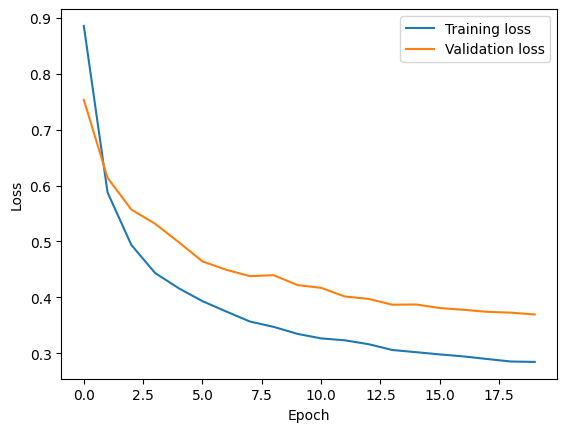

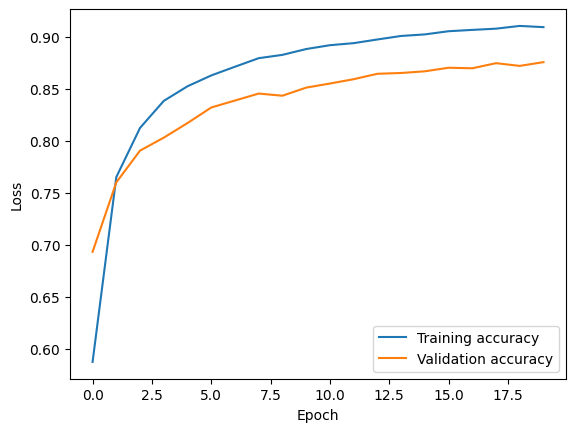

In [84]:
##PLotting

plt.plot(train_losses_np, label='Training loss')
plt.plot(valid_losses_np, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
##Load the model from the checkpoint

timestep = 7
window = 50
batch_size = 8
device = torch.device("mps")
model = CDCK2(timestep, batch_size, window)
PATH = "project2_TS_output/cdc-2024-05-15_12_08_10-model_best.pth"

# Load the checkpoint
checkpoint = torch.load(PATH)

# Extract the state_dict from the loaded checkpoint
state_dict = checkpoint['state_dict']

# Load the state_dict into your model
model.load_state_dict(state_dict)

# Move your model to the appropriate device (e.g., GPU or CPU)
model.to(device)

CDCK2(
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 64, kernel_size=(5,), stride=(4,), padding=(1,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (gru): GRU(64, 256, batch_first=True)
  (Wk): ModuleList(
    (0-6): 7 x Linear(in_features=256, out_features=64, bias=True)
  )
  (softmax): Softmax(dim=None)
  (lsoftmax): LogSoftmax(dim=None)
)

In [99]:
##create embeddings for the mitbih dataset
def create_embeddings(model, data_loader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for [data, target] in data_loader:
            #print ("before unsqueeze",data.size())
            data = data.unsqueeze(1).to(device) # add channel dimension
            #print ("after unsqueeze",data.size())
            output= model.encoder(data)
            # Assume 'output' is the tensor from self.encoder(input)
            output_flattened = output.view(output.size(0), -1)
            embeddings.append(output_flattened.detach().cpu().numpy())
            labels.append(target.numpy())

        # Concatenate all data and labels
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    return embeddings, labels

train_embeddings, train_labels = create_embeddings(model, train_loader, device)
test_embeddings, test_labels = create_embeddings(model, validation_loader, device)


In [28]:
# train a classifier (random forest) on top of the embeddings

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [27]:
rf = RandomForestClassifier(random_state=42)

#print(train_embeddings)
print(train_embeddings.shape)
print(train_labels.shape)
rf.fit(train_embeddings, train_labels)
    

NameError: name 'train_embeddings' is not defined

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     18118
         1.0       0.98      0.59      0.74       556
         2.0       0.98      0.89      0.93      1448
         3.0       0.87      0.60      0.71       162
         4.0       1.00      0.95      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.96      0.80      0.87     21892
weighted avg       0.97      0.97      0.97     21892

F1:  0.8674589985395021
Accuracy: 0.9746


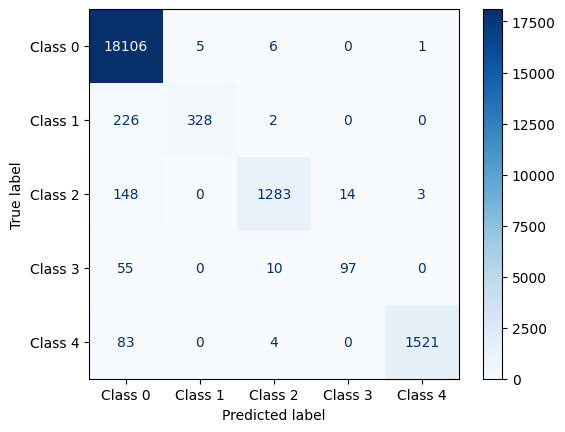

In [106]:
pred = rf.predict(test_embeddings)

cm = ConfusionMatrixDisplay.from_predictions(test_labels, pred, 
                                            display_labels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], 
                                            cmap='Blues', 
                                            normalize=None)
 
print(classification_report(test_labels, pred))
print("F1: ",f1_score(test_labels, pred, average='macro'))
print(f'Accuracy: {accuracy_score(test_labels, pred):.4f}')

# Q3: Visualising Learned Representations

In [117]:
from sklearn.manifold import TSNE

def plot_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2, perplexity= 40, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter, ticks=np.unique(labels))
    plt.show()

In [15]:
#import ptb dataset
train_set_ptb = pd.read_csv("project2_TS_input/ptbdb_train.csv", header=None)
test_set_ptb = pd.read_csv("project2_TS_input/ptbdb_test.csv", header=None)

y_train_ptb=train_set_ptb.iloc[:,-1]
X_train_ptb = train_set_ptb.iloc[:,:-1]
y_test_ptb=test_set_ptb.iloc[:,-1]
X_test_ptb = test_set_ptb.iloc[:,:-1]

In [16]:
#create loaders for ptb dataset
X_train_tensor_ptb = torch.tensor(X_train_ptb.values , dtype=torch.float)
y_train_tensor_ptb = torch.tensor(y_train_ptb, dtype=torch.float32).view(-1, 1)

X_test_tensor_ptb = torch.tensor(X_test_ptb.values , dtype=torch.float)
y_test_tensor_ptb = torch.tensor(y_test_ptb, dtype=torch.float32).view(-1, 1)

# Create a DataLoader for each dataset
batch_size = 8
train_loader_ptb = data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor_ptb, y_train_tensor_ptb), batch_size=batch_size, shuffle=True)
test_loader_ptb = data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor_ptb, y_test_tensor_ptb), batch_size=batch_size, shuffle=False)
valid_loader_ptb = data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor_ptb, y_test_tensor_ptb), batch_size=batch_size, shuffle=False)

In [111]:
# Create embeddings for the mit dataset
mit_train_embeddings, mit_train_labels = create_embeddings(model, train_loader, device)
mit_test_embeddings, mit_test_labels = create_embeddings(model, validation_loader, device)

In [131]:
print("MIT train embeddings shape: ", mit_train_embeddings.shape)

MIT train embeddings shape:  (87554, 3008)


In [114]:
#create embeddings for the ptb dataset
ptb_train_embeddings, ptb_train_labels = create_embeddings(model, train_loader_ptb, device)
ptb_test_embeddings, ptb_test_labels = create_embeddings(model, test_loader_ptb, device)

In [132]:
print("PTB train embeddings shape: ", ptb_train_embeddings.shape)

PTB train embeddings shape:  (11641, 3008)


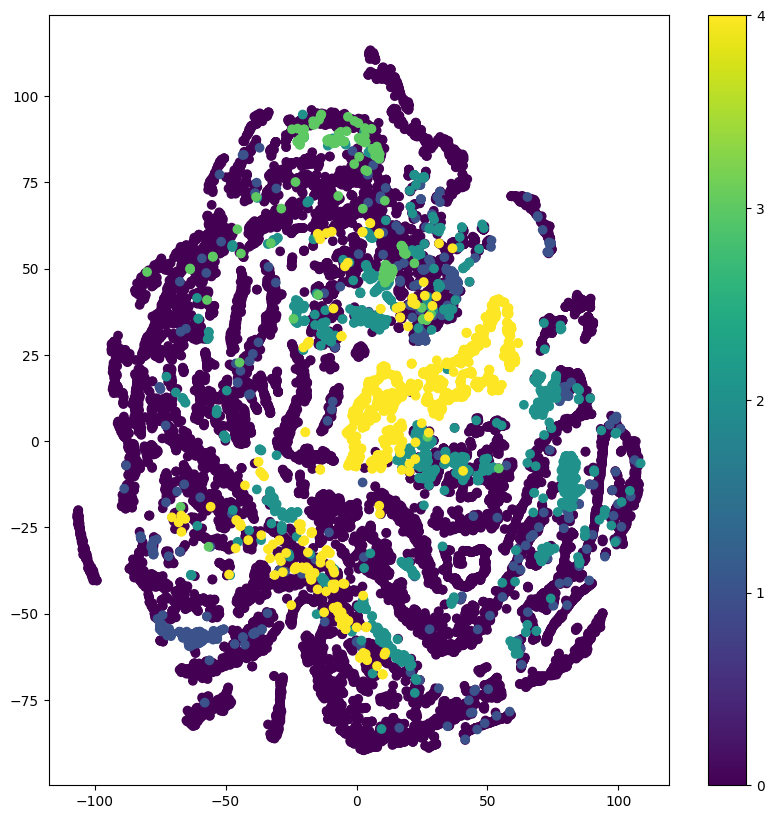

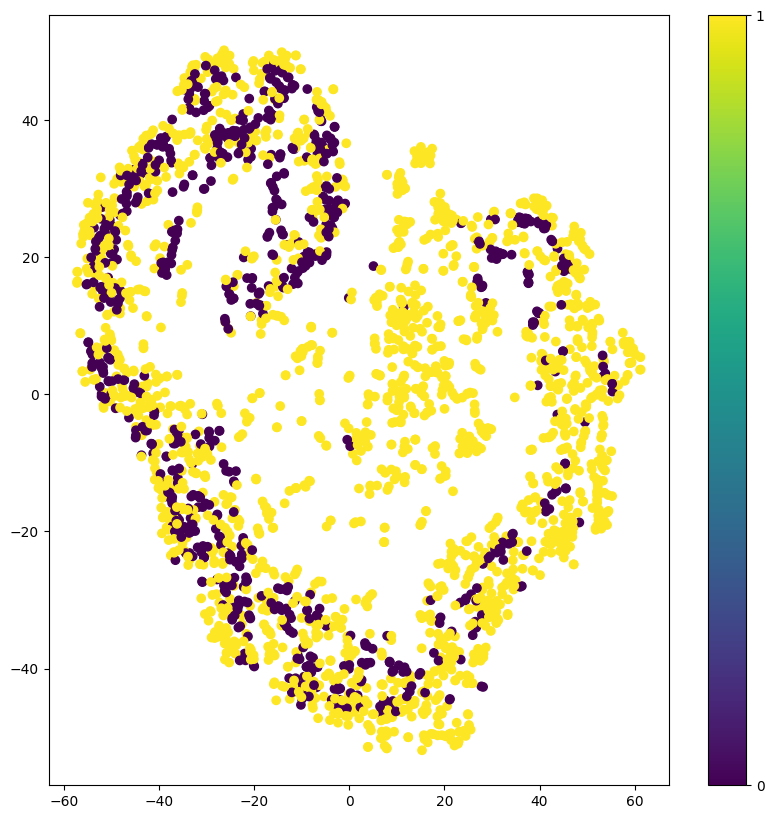

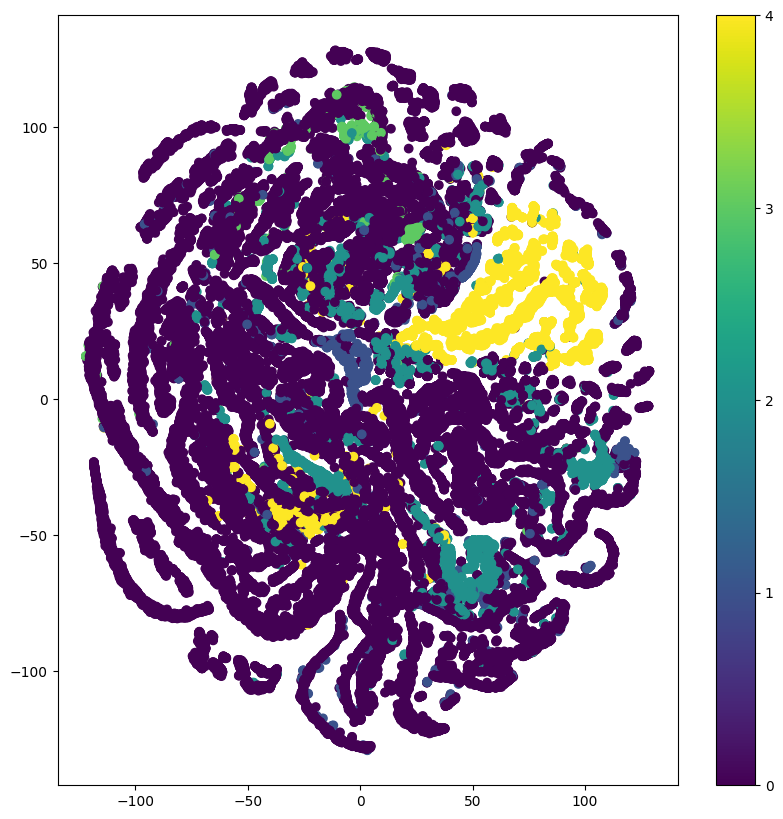

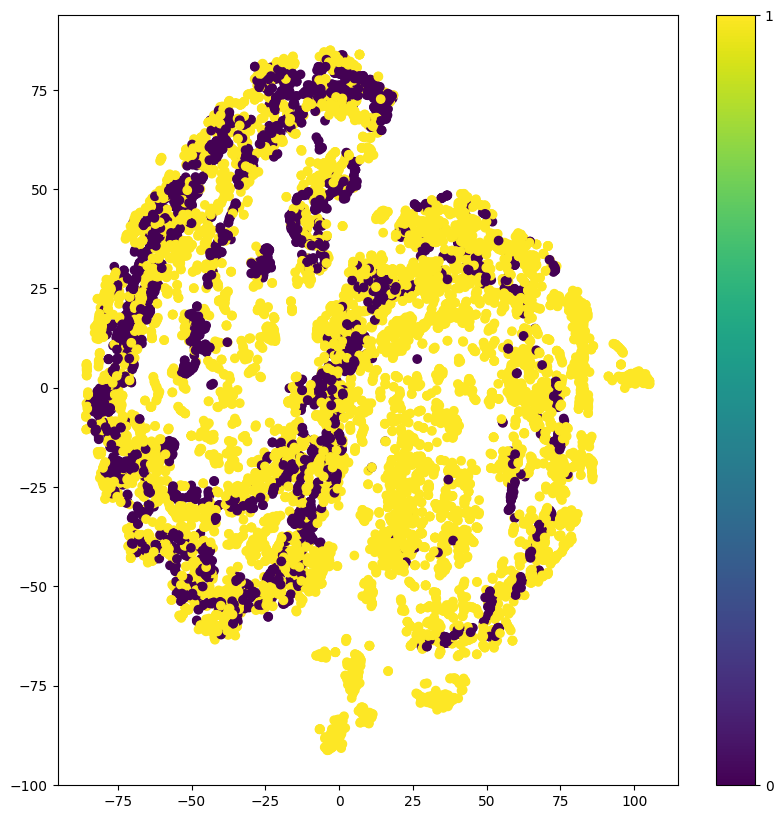

In [118]:
plot_embeddings(mit_test_embeddings, mit_test_labels)
plot_embeddings(ptb_test_embeddings, ptb_test_labels)
plot_embeddings(mit_train_embeddings, mit_train_labels)
plot_embeddings(ptb_train_embeddings, ptb_train_labels)


# Q4: Finetuning Strategies

## 1. Classic ML method

In [119]:
# Train a random forest classifier on the PTB dataset
rf_ptb = RandomForestClassifier(random_state=42)
rf_ptb.fit(ptb_train_embeddings, ptb_train_labels)


/opt/homebrew/Caskroom/miniconda/base/envs/pai-task2/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       809
         1.0       0.97      1.00      0.98      2102

    accuracy                           0.97      2911
   macro avg       0.98      0.96      0.97      2911
weighted avg       0.97      0.97      0.97      2911

F1:  0.9667520273154077
Accuracy: 0.9739


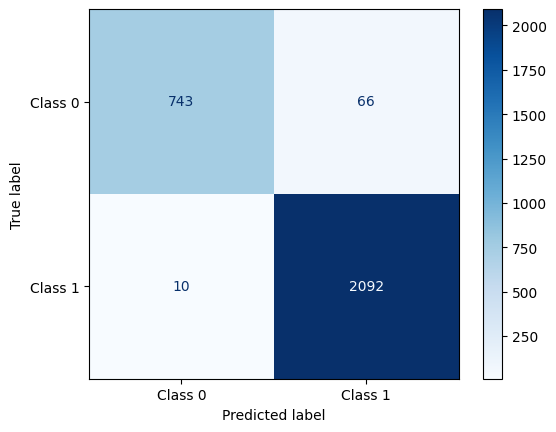

In [120]:
pred_ptb = rf_ptb.predict(ptb_test_embeddings)

cm = ConfusionMatrixDisplay.from_predictions(ptb_test_labels, pred_ptb, 
                                            display_labels=['Class 0', 'Class 1'], 
                                            cmap='Blues', 
                                            normalize=None)
 
print(classification_report(ptb_test_labels, pred_ptb))
print("F1: ",f1_score(ptb_test_labels, pred_ptb, average='macro'))
print(f'Accuracy: {accuracy_score(ptb_test_labels, pred_ptb):.4f}')

# 2. MLP output layers  

### Training the output layer(s) only

freeze encoder layers, add a binary classification layer to finetune on ptb dataset

In [10]:
# create a new class for the models CPC_Classifier= CPC.encoder + MLP output layer
class CPC_Classifier(nn.Module):
    def __init__(self, encoder):
        super(CPC_Classifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(3008,1)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [18]:
from copy import deepcopy

# Copy the pretrained model encoder
model_A_CPC_encoder = deepcopy(model.encoder)

# Create a new model with the copied encoder
model_A_CPC = CPC_Classifier(model_A_CPC_encoder)

# Freeze the encoder block
for param in model_A_CPC.encoder.parameters():
    param.requires_grad = False

print(model_A_CPC)

# Move the model to the appropriate device
model_A_CPC.to(device)



CPC_Classifier(
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 64, kernel_size=(5,), stride=(4,), padding=(1,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=3008, out_features=1, bias=True)
)


CPC_Classifier(
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 64, kernel_size=(5,), stride=(4,), padding=(1,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=3008, out_features=1, bias=True)
)

In [19]:
def train_ptb(model,optimizer,criterion):
    device = torch.device("mps")
    train_losses = []
    epochs=10

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for timeseries, labels in tqdm(train_loader_ptb):
            timeseries, labels = timeseries.unsqueeze(1).to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(timeseries)
            # probabilities = torch.softmax(output, dim=1)
            # _, predicted_classes = torch.max(probabilities, 1)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader_ptb)
        train_losses.append(train_loss)

        print(f"Epoch {epoch + 1}/{epochs}.. "
                f"Train loss: {train_loss:.3f}")


    plt.plot(train_losses, label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 1456/1456 [00:05<00:00, 252.96it/s]


Epoch 1/10.. Train loss: 0.238


100%|██████████| 1456/1456 [00:04<00:00, 322.77it/s]


Epoch 2/10.. Train loss: 0.160


100%|██████████| 1456/1456 [00:04<00:00, 326.28it/s]


Epoch 3/10.. Train loss: 0.128


100%|██████████| 1456/1456 [00:04<00:00, 324.70it/s]


Epoch 4/10.. Train loss: 0.118


100%|██████████| 1456/1456 [00:04<00:00, 326.04it/s]


Epoch 5/10.. Train loss: 0.104


100%|██████████| 1456/1456 [00:04<00:00, 333.67it/s]


Epoch 6/10.. Train loss: 0.096


100%|██████████| 1456/1456 [00:04<00:00, 319.92it/s]


Epoch 7/10.. Train loss: 0.093


100%|██████████| 1456/1456 [00:04<00:00, 331.71it/s]


Epoch 8/10.. Train loss: 0.088


100%|██████████| 1456/1456 [00:04<00:00, 317.77it/s]


Epoch 9/10.. Train loss: 0.081


100%|██████████| 1456/1456 [00:04<00:00, 324.00it/s]


Epoch 10/10.. Train loss: 0.078


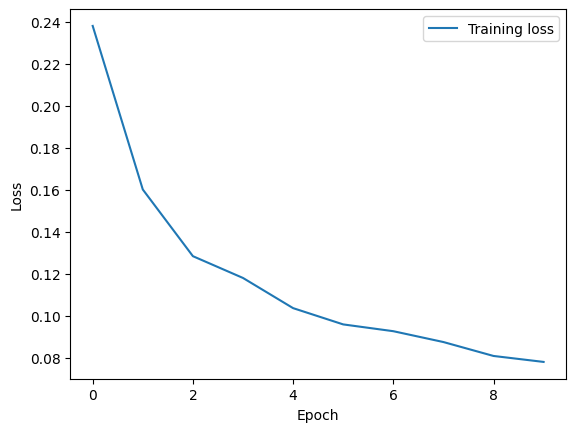

In [20]:
optimizer_A = optim.Adam(model_A_CPC.classifier.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Binary classification for PTB dataset

train_ptb(model_A_CPC,optimizer_A,criterion)

In [37]:
def evaluate_ptb(model, test_loader,criterion):
    '''
    Evaluate the model on the test set
    '''
    model.eval()
    test_loss = 0.0
    correct = 0
    device = torch.device("mps")


    with torch.no_grad():
        for timeseries, labels in test_loader:
            timeseries, labels = timeseries.unsqueeze(1).to(device), labels.to(device)
            output = model(timeseries)
            labels = labels.float()
            #print(labels.shape)
            loss = criterion(output, labels)
            test_loss += loss.item()
            preds = torch.round(torch.sigmoid(output))
            correct += (preds == labels).sum().item()
            
            test_loss /= len(test_loader)
            accuracy = correct / len(test_loader.dataset)

            print(f"Test loss: {test_loss:.3f}.. "
                  f"Test accuracy: {accuracy:.3f}")

            # Move labels and preds to CPU before converting to numpy
            labels_cpu = labels.cpu().numpy()
            preds_cpu = preds.cpu().numpy()

            cm = ConfusionMatrixDisplay.from_predictions(labels_cpu, preds_cpu, 
                                                        display_labels=['Class 0', 'Class 1'], 
                                                        cmap='Blues', 
                                                        normalize=None)
            print(classification_report(labels_cpu, preds_cpu))
            print("F1: ", f1_score(labels_cpu, preds_cpu))

    
    
    return test_loss, accuracy

Test loss: 0.125.. Test accuracy: 0.957
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92       809
         1.0       0.95      0.99      0.97      2102

    accuracy                           0.96      2911
   macro avg       0.96      0.93      0.95      2911
weighted avg       0.96      0.96      0.96      2911

F1:  0.9710280373831777


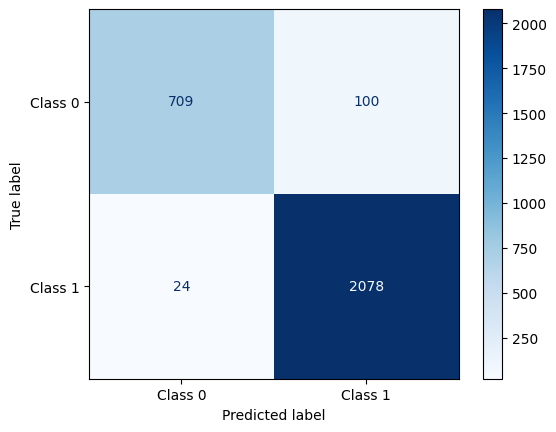

In [39]:
test_loader_ptb_no_batches = data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor_ptb, y_test_tensor_ptb), batch_size=X_test_tensor_ptb.shape[0], shuffle=False)

test_loss_A, accuracy_B = evaluate_ptb(model_A_CPC, test_loader_ptb_no_batches, nn.BCEWithLogitsLoss())

In [41]:
save_model = {
    'state_dict': model_A_CPC.state_dict(),
    'optimizer': optimizer_A.state_dict()
}

torch.save(save_model, 'project2_TS_output/Model_A_CPC.pth')

### B. Train the entire model on the PTB dataset (encoder+outputlayers)

First train the CPC model from scratch on the ptb dataset:

In [127]:
train_losses_ptb = []
train_accuracies_ptb = []
valid_losses_ptb = []
valid_accuracies_ptb = []

In [128]:
### MODEL B for PTB dataset

run_name_B = "cdc_model_B" + time.strftime("-%Y-%m-%d_%H_%M_%S")
print(run_name_B)

global_timer = timer() # global timer
device = torch.device("mps")
timestep = 7
window = 50
batch_size = 8

model_B= CDCK2(timestep, batch_size, window).to(device)

logger.info('===> loading train, validation and eval dataset')

optimizer_B = ScheduledOptim(
    optim.Adam(
        filter(lambda p: p.requires_grad, model_B.parameters()), 
        betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True),
    16)

model_B_params = sum(p.numel() for p in model_B.parameters() if p.requires_grad)
logger.info('### Model B summary below###\n {}\n'.format(str(model_B)))
logger.info('===> Model B total parameter: {}\n'.format(model_B_params))


## Start training
best_acc = 0
best_loss = np.inf
best_epoch = -1 
n_epochs = 40


for epoch in range(1, n_epochs + 1):
    epoch_timer = timer()

    # Train and validate
    train_acc, train_loss = train(50, model_B, device, train_loader_ptb, optimizer_B, epoch, batch_size)
    val_acc, val_loss = validation(model_B, device, test_loader_ptb, batch_size)

    train_losses_ptb.append(train_loss)
    train_accuracies_ptb.append(train_acc)
    valid_losses_ptb.append(val_loss)
    valid_accuracies_ptb.append(val_acc)
    
    # Save
    if val_acc > best_acc: 
        best_acc = max(val_acc, best_acc)
        snapshot("project2_TS_output", run_name_B, {
            'epoch': epoch + 1,
            'validation_acc': val_acc, 
            'state_dict': model_B.state_dict(),
            'validation_loss': val_loss,
            'optimizer_B': optimizer_B.state_dict(),
        })
        best_epoch = epoch + 1
    elif epoch - best_epoch > 2:
        optimizer_B.increase_delta()
        best_epoch = epoch + 1
    
    end_epoch_timer = timer()
    logger.info("#### End epoch {}/{}, elapsed time: {}".format(epoch, 20, end_epoch_timer - epoch_timer))


## end 
end_global_timer = timer()
logger.info("################## Success #########################")
logger.info("Total elapsed time: %s" % (end_global_timer - global_timer))



cdc_model_B-2024-05-17_18_16_12


  0%|          | 0/1456 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/pai-task2/lib/python3.8/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/pai-task2/lib/python3.8/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 1456/1456 [00:39<00:00, 37.32it/s]


Train Epoch: 1 	lr:0.00232	Accuracy: 0.4317	Loss: 1.232489
===> Validation set: Average loss: 1.0538	Accuracy: 0.4827



100%|██████████| 1456/1456 [00:38<00:00, 37.74it/s]


Train Epoch: 2 	lr:0.00164	Accuracy: 0.4921	Loss: 1.010196
===> Validation set: Average loss: 1.0046	Accuracy: 0.5270



100%|██████████| 1456/1456 [00:38<00:00, 37.87it/s]


Train Epoch: 3 	lr:0.00134	Accuracy: 0.5276	Loss: 0.937599
===> Validation set: Average loss: 0.9228	Accuracy: 0.5459



100%|██████████| 1456/1456 [00:38<00:00, 37.70it/s]


Train Epoch: 4 	lr:0.00116	Accuracy: 0.5523	Loss: 0.892246
===> Validation set: Average loss: 0.8883	Accuracy: 0.5665



100%|██████████| 1456/1456 [00:38<00:00, 37.99it/s]


Train Epoch: 5 	lr:0.00104	Accuracy: 0.5663	Loss: 0.857606
===> Validation set: Average loss: 0.8619	Accuracy: 0.5878



100%|██████████| 1456/1456 [00:38<00:00, 38.09it/s]


Train Epoch: 6 	lr:0.00095	Accuracy: 0.6047	Loss: 0.806265
===> Validation set: Average loss: 0.8146	Accuracy: 0.6359



100%|██████████| 1456/1456 [00:38<00:00, 38.27it/s]


Train Epoch: 7 	lr:0.00088	Accuracy: 0.6508	Loss: 0.772379
===> Validation set: Average loss: 0.7576	Accuracy: 0.6651



100%|██████████| 1456/1456 [00:38<00:00, 38.00it/s]


Train Epoch: 8 	lr:0.00082	Accuracy: 0.6827	Loss: 0.706473
===> Validation set: Average loss: 0.7094	Accuracy: 0.6929



100%|██████████| 1456/1456 [00:38<00:00, 38.17it/s]


Train Epoch: 9 	lr:0.00077	Accuracy: 0.6942	Loss: 0.693759
===> Validation set: Average loss: 0.7135	Accuracy: 0.7053



100%|██████████| 1456/1456 [00:38<00:00, 37.96it/s]


Train Epoch: 10 	lr:0.00073	Accuracy: 0.7025	Loss: 0.667142
===> Validation set: Average loss: 0.7054	Accuracy: 0.7008



100%|██████████| 1456/1456 [00:39<00:00, 37.07it/s]


Train Epoch: 11 	lr:0.00070	Accuracy: 0.7163	Loss: 0.637565
===> Validation set: Average loss: 0.7354	Accuracy: 0.6915



100%|██████████| 1456/1456 [00:38<00:00, 38.02it/s]


Train Epoch: 12 	lr:0.00067	Accuracy: 0.7139	Loss: 0.635102
===> Validation set: Average loss: 0.6397	Accuracy: 0.7241



100%|██████████| 1456/1456 [00:38<00:00, 37.94it/s]


Train Epoch: 13 	lr:0.00064	Accuracy: 0.7277	Loss: 0.630180
===> Validation set: Average loss: 0.6335	Accuracy: 0.7499



100%|██████████| 1456/1456 [00:40<00:00, 36.39it/s]


Train Epoch: 14 	lr:0.00062	Accuracy: 0.7315	Loss: 0.616234
===> Validation set: Average loss: 0.6237	Accuracy: 0.7444



100%|██████████| 1456/1456 [00:40<00:00, 36.29it/s]


Train Epoch: 15 	lr:0.00060	Accuracy: 0.7367	Loss: 0.616608
===> Validation set: Average loss: 0.6384	Accuracy: 0.7286



100%|██████████| 1456/1456 [00:40<00:00, 36.28it/s]


Train Epoch: 16 	lr:0.00058	Accuracy: 0.7400	Loss: 0.605745
===> Validation set: Average loss: 0.5997	Accuracy: 0.7485



100%|██████████| 1456/1456 [00:40<00:00, 36.02it/s]


Train Epoch: 17 	lr:0.00056	Accuracy: 0.7508	Loss: 0.581137
===> Validation set: Average loss: 0.6122	Accuracy: 0.7516



100%|██████████| 1456/1456 [00:40<00:00, 36.17it/s]


Train Epoch: 18 	lr:0.00055	Accuracy: 0.7443	Loss: 0.582436
===> Validation set: Average loss: 0.5868	Accuracy: 0.7692



100%|██████████| 1456/1456 [00:40<00:00, 36.37it/s]


Train Epoch: 19 	lr:0.00053	Accuracy: 0.7596	Loss: 0.568438
===> Validation set: Average loss: 0.6207	Accuracy: 0.7492



100%|██████████| 1456/1456 [00:39<00:00, 36.50it/s]


Train Epoch: 20 	lr:0.00052	Accuracy: 0.7559	Loss: 0.564301
===> Validation set: Average loss: 0.5723	Accuracy: 0.7630



100%|██████████| 1456/1456 [00:39<00:00, 36.59it/s]


Train Epoch: 21 	lr:0.00051	Accuracy: 0.7510	Loss: 0.579622
===> Validation set: Average loss: 0.6044	Accuracy: 0.7523



100%|██████████| 1456/1456 [00:39<00:00, 36.47it/s]


Train Epoch: 22 	lr:0.00049	Accuracy: 0.7620	Loss: 0.560227
===> Validation set: Average loss: 0.5580	Accuracy: 0.7784



100%|██████████| 1456/1456 [02:59<00:00,  8.12it/s] 


Train Epoch: 23 	lr:0.00048	Accuracy: 0.7679	Loss: 0.549830
===> Validation set: Average loss: 0.5915	Accuracy: 0.7637



100%|██████████| 1456/1456 [00:39<00:00, 36.43it/s]


Train Epoch: 24 	lr:0.00047	Accuracy: 0.7694	Loss: 0.547423
===> Validation set: Average loss: 0.5822	Accuracy: 0.7688



100%|██████████| 1456/1456 [00:39<00:00, 36.53it/s]


Train Epoch: 25 	lr:0.00046	Accuracy: 0.7664	Loss: 0.550187
===> Validation set: Average loss: 0.5333	Accuracy: 0.7901



100%|██████████| 1456/1456 [00:39<00:00, 36.45it/s]


Train Epoch: 26 	lr:0.00045	Accuracy: 0.7785	Loss: 0.546319
===> Validation set: Average loss: 0.5321	Accuracy: 0.7949



100%|██████████| 1456/1456 [00:40<00:00, 35.53it/s]


Train Epoch: 27 	lr:0.00045	Accuracy: 0.7732	Loss: 0.536029
===> Validation set: Average loss: 0.5745	Accuracy: 0.7613



100%|██████████| 1456/1456 [00:42<00:00, 34.02it/s]


Train Epoch: 28 	lr:0.00044	Accuracy: 0.7854	Loss: 0.518932
===> Validation set: Average loss: 0.5836	Accuracy: 0.7640



100%|██████████| 1456/1456 [00:44<00:00, 32.52it/s]


Train Epoch: 29 	lr:0.00043	Accuracy: 0.7798	Loss: 0.527719
===> Validation set: Average loss: 0.5643	Accuracy: 0.7630



100%|██████████| 1456/1456 [00:41<00:00, 35.12it/s]


Train Epoch: 30 	lr:0.00042	Accuracy: 0.7876	Loss: 0.521868
===> Validation set: Average loss: 0.5342	Accuracy: 0.8008



100%|██████████| 1456/1456 [00:41<00:00, 35.19it/s]


Train Epoch: 31 	lr:0.00042	Accuracy: 0.7735	Loss: 0.528494
===> Validation set: Average loss: 0.5541	Accuracy: 0.7753



100%|██████████| 1456/1456 [00:42<00:00, 34.62it/s]


Train Epoch: 32 	lr:0.00041	Accuracy: 0.7757	Loss: 0.529377
===> Validation set: Average loss: 0.5331	Accuracy: 0.7990



100%|██████████| 1456/1456 [00:41<00:00, 35.46it/s]


Train Epoch: 33 	lr:0.00040	Accuracy: 0.7852	Loss: 0.517481
===> Validation set: Average loss: 0.5143	Accuracy: 0.7935



100%|██████████| 1456/1456 [00:40<00:00, 35.71it/s]


Train Epoch: 34 	lr:0.00040	Accuracy: 0.7998	Loss: 0.498917
===> Validation set: Average loss: 0.5373	Accuracy: 0.7946



100%|██████████| 1456/1456 [00:40<00:00, 36.39it/s]


Train Epoch: 35 	lr:0.00039	Accuracy: 0.7909	Loss: 0.500293
===> Validation set: Average loss: 0.5370	Accuracy: 0.7825



100%|██████████| 1456/1456 [00:39<00:00, 36.62it/s]


Train Epoch: 36 	lr:0.00038	Accuracy: 0.7874	Loss: 0.515073
===> Validation set: Average loss: 0.5173	Accuracy: 0.7949



100%|██████████| 1456/1456 [03:36<00:00,  6.72it/s]


Train Epoch: 37 	lr:0.00037	Accuracy: 0.8018	Loss: 0.497492
===> Validation set: Average loss: 0.5537	Accuracy: 0.7856



100%|██████████| 1456/1456 [17:55<00:00,  1.35it/s]  


Train Epoch: 38 	lr:0.00036	Accuracy: 0.7934	Loss: 0.493046
===> Validation set: Average loss: 0.5337	Accuracy: 0.8011



100%|██████████| 1456/1456 [17:08<00:00,  1.42it/s]  


Train Epoch: 39 	lr:0.00035	Accuracy: 0.7998	Loss: 0.486002
===> Validation set: Average loss: 0.5147	Accuracy: 0.7959



100%|██████████| 1456/1456 [15:55<00:00,  1.52it/s]  


Train Epoch: 40 	lr:0.00034	Accuracy: 0.7955	Loss: 0.496448
===> Validation set: Average loss: 0.5322	Accuracy: 0.8049



In [129]:
train_losses_ptb_np = []
for i in range(0, len(train_losses_ptb)):
    train_losses_ptb_np.append(train_losses_ptb[i].item())

valid_losses_ptb_np = []
for i in range(0, len(valid_losses_ptb)):
    valid_losses_ptb_np.append(valid_losses_ptb[i].item())


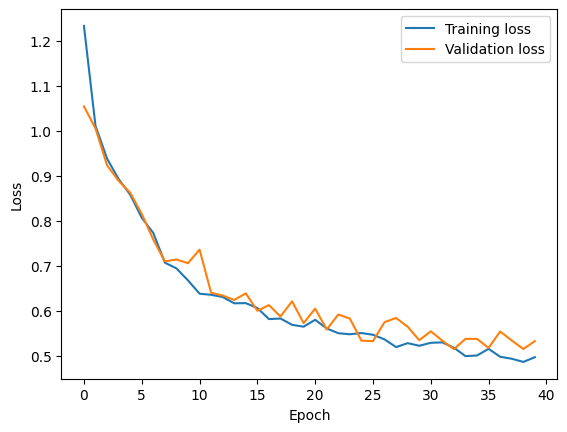

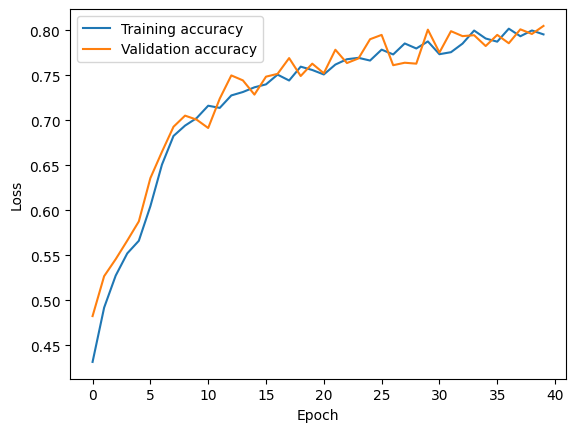

In [130]:
##PLotting

plt.plot(train_losses_ptb_np, label='Training loss')
plt.plot(valid_losses_ptb_np, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies_ptb, label='Training accuracy')
plt.plot(valid_accuracies_ptb, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Now create a new CPC_Classifier model with this new pretrained encoder

In [44]:
##Load the model from the checkpoint

timestep = 7
window = 50
batch_size = 8
device = torch.device("mps")
model_B = CDCK2(timestep, batch_size, window)
PATH = "project2_TS_output/cdc_model_B-2024-05-17_18_16_12-model_best.pth"

# Load the checkpoint
checkpoint = torch.load(PATH)

# Extract the state_dict from the loaded checkpoint
state_dict = checkpoint['state_dict']

# Load the state_dict into your model
model_B.load_state_dict(state_dict)

# Move your model to the appropriate device (e.g., GPU or CPU)
model_B.to(device)

CDCK2(
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 64, kernel_size=(5,), stride=(4,), padding=(1,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (gru): GRU(64, 256, batch_first=True)
  (Wk): ModuleList(
    (0-6): 7 x Linear(in_features=256, out_features=64, bias=True)
  )
  (softmax): Softmax(dim=None)
  (lsoftmax): LogSoftmax(dim=None)
)

In [47]:
from copy import deepcopy
device = torch.device("mps")
# Copy the pretrained model encoder
model_B_CPC_encoder = deepcopy(model_B.encoder)

# Create a new model with the copied encoder
model_B_CPC = CPC_Classifier(model_B_CPC_encoder)

# Freeze the encoder block
for param in model_B_CPC.encoder.parameters():
    param.requires_grad = False

# Move the model to the appropriate device
model_B_CPC.to(device)



CPC_Classifier(
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 64, kernel_size=(5,), stride=(4,), padding=(1,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=3008, out_features=1, bias=True)
)

100%|██████████| 1456/1456 [00:04<00:00, 319.89it/s]


Epoch 1/10.. Train loss: 0.251


100%|██████████| 1456/1456 [00:04<00:00, 324.08it/s]


Epoch 2/10.. Train loss: 0.176


100%|██████████| 1456/1456 [00:04<00:00, 301.53it/s]


Epoch 3/10.. Train loss: 0.148


100%|██████████| 1456/1456 [00:04<00:00, 312.68it/s]


Epoch 4/10.. Train loss: 0.134


100%|██████████| 1456/1456 [00:04<00:00, 321.81it/s]


Epoch 5/10.. Train loss: 0.123


100%|██████████| 1456/1456 [00:04<00:00, 321.05it/s]


Epoch 6/10.. Train loss: 0.114


100%|██████████| 1456/1456 [00:04<00:00, 329.09it/s]


Epoch 7/10.. Train loss: 0.106


100%|██████████| 1456/1456 [00:04<00:00, 317.68it/s]


Epoch 8/10.. Train loss: 0.100


100%|██████████| 1456/1456 [00:04<00:00, 303.15it/s]


Epoch 9/10.. Train loss: 0.099


100%|██████████| 1456/1456 [00:04<00:00, 310.92it/s]

Epoch 10/10.. Train loss: 0.092


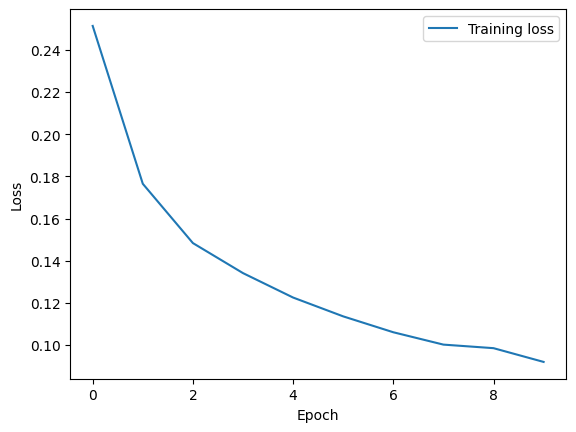

In [49]:
optimizer_B = optim.Adam(model_B_CPC.classifier.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Binary classification for PTB dataset

train_ptb(model_B_CPC,optimizer_B,criterion)

Test loss: 0.115.. Test accuracy: 0.959
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93       809
         1.0       0.96      0.98      0.97      2102

    accuracy                           0.96      2911
   macro avg       0.96      0.94      0.95      2911
weighted avg       0.96      0.96      0.96      2911

F1:  0.9721698113207548


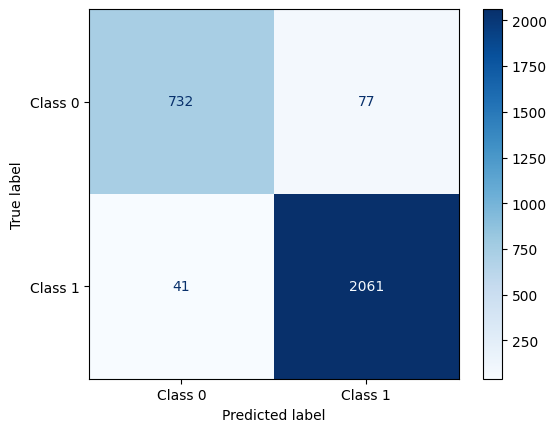

In [50]:
test_loader_ptb_no_batches = data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor_ptb, y_test_tensor_ptb), batch_size=X_test_tensor_ptb.shape[0], shuffle=False)

test_loss_B, accuracy_B = evaluate_ptb(model_B_CPC, test_loader_ptb_no_batches, nn.BCEWithLogitsLoss())

In [51]:
save_model = {
    'state_dict': model_B_CPC.state_dict(),
    'optimizer': optimizer_B.state_dict()
}

torch.save(save_model, 'project2_TS_output/Model_B_CPC.pth')

### C. First, train the output layers, then unfreeze and train the entire joint model in two separate stages.

first copy model A  (encoder trained on mit, output layer trained on ptb), unfreeze the encoder and retrain the whole model on ptb. 

In [53]:
# Copy the model A : it has encoder (convolutions layers) trained on mit and output linear layer trained on ptb. 
model_C_CPC = deepcopy(model_A_CPC)

# Unfreeze the convolutional layers
for param in model_C_CPC.parameters():
    param.requires_grad = True

100%|██████████| 1456/1456 [00:09<00:00, 159.56it/s]


Epoch 1/10.. Train loss: 0.158


100%|██████████| 1456/1456 [00:07<00:00, 204.56it/s]


Epoch 2/10.. Train loss: 0.108


100%|██████████| 1456/1456 [00:07<00:00, 203.33it/s]


Epoch 3/10.. Train loss: 0.096


100%|██████████| 1456/1456 [00:07<00:00, 204.23it/s]


Epoch 4/10.. Train loss: 0.093


100%|██████████| 1456/1456 [00:07<00:00, 199.64it/s]


Epoch 5/10.. Train loss: 0.079


100%|██████████| 1456/1456 [00:07<00:00, 207.75it/s]


Epoch 6/10.. Train loss: 0.069


100%|██████████| 1456/1456 [00:07<00:00, 202.09it/s]


Epoch 7/10.. Train loss: 0.068


100%|██████████| 1456/1456 [00:07<00:00, 206.75it/s]


Epoch 8/10.. Train loss: 0.066


100%|██████████| 1456/1456 [00:06<00:00, 218.57it/s]


Epoch 9/10.. Train loss: 0.059


100%|██████████| 1456/1456 [00:06<00:00, 217.00it/s]


Epoch 10/10.. Train loss: 0.053


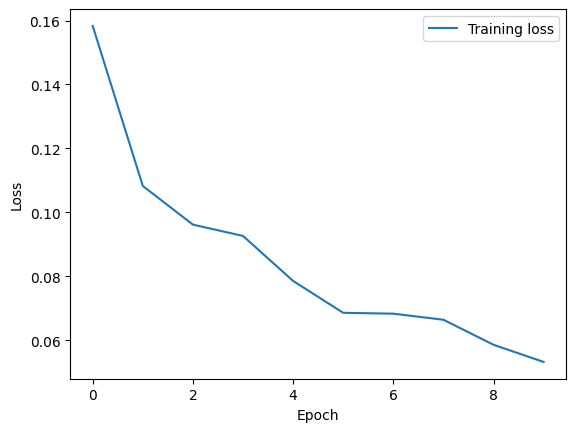

In [54]:
# TRAIN ENTIRE MODEL

# Define the loss function and the optimizer
optimizer_C = optim.Adam(model_C_CPC.parameters(), lr=0.001)
criterion_C = nn.BCEWithLogitsLoss()  # Binary classification for PTB dataset

train_ptb(model_C_CPC,optimizer_C,criterion_C)

Test loss: 0.108.. Test accuracy: 0.968
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       809
         1.0       0.98      0.98      0.98      2102

    accuracy                           0.97      2911
   macro avg       0.96      0.96      0.96      2911
weighted avg       0.97      0.97      0.97      2911

F1:  0.9781576448243114


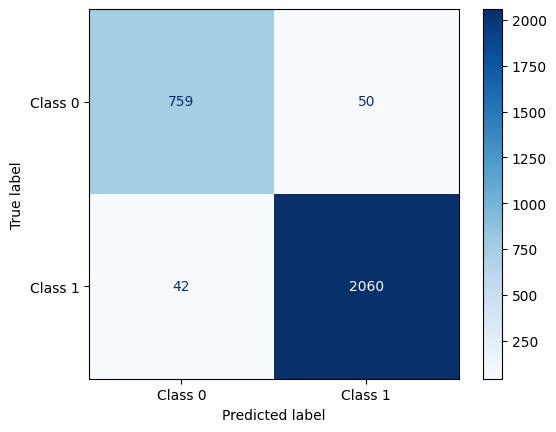

In [55]:
test_loader_ptb_no_batches = data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor_ptb, y_test_tensor_ptb), batch_size=X_test_tensor_ptb.shape[0], shuffle=False)

test_loss_C, accuracy_C = evaluate_ptb(model_C_CPC, test_loader_ptb_no_batches, nn.BCEWithLogitsLoss())

In [56]:
save_model = {
    'state_dict': model_C_CPC.state_dict(),
    'optimizer': optimizer_C.state_dict()
}

torch.save(save_model, 'project2_TS_output/Model_C_CPC.pth')